In [1]:
#!/usr/bin/env python

# Idaelized-core_example.ipynb

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm

from tqdm import tqdm

In [2]:
from draft_functions import core_2d_properties, core_3d_properties

### SET IDEALIZED CORE PROPERTIES

In [3]:
dx = 100 # m - grid spacing of domain
ilon = 250 # grid cells in logitude direction
ilat = 100 # grid cells in latitude direction
top = 15000  # m - top of domain
dt = 1 # s
itime = 600 # time steps

radius = 1000    # radius of draft
draft_corespeed_all = [5,10,15,20] # 15 # m/s
horizontal_advection_all = [10,20,30,40,50] #30 # m/s
draft_th = 1 # minimum draft speed

### derived settings
ilev = int(top/dx)
start_height = int(radius/dx * 1.2)
start_lon = int(radius/dx * 1.2)
start_lat = int(ilat / 2)

# center_heigt_time = np.linspace(start_height, start_height + (draft_corespeed * dt * itime)/dx, itime).astype(int)
# center_lon_time = np.linspace(start_lon, start_lon + (horizontal_advection * dt * itime)/dx, itime).astype(int)

# # create important matrizes
# data = np.zeros((itime, ilev, ilat, ilon))
# height = np.linspace(0,top,ilev+1)
# lon_m = np.linspace(0,dx*ilon,ilon+1)
# lat_m = np.linspace(0,dx*ilat,ilat+1)

# length = np.arange(0,itime,dt) * horizontal_advection

# # create 3d coordinate arrays
# height3D = np.repeat(np.repeat(height[:-1,np.newaxis],ilat, axis=1)[:,:,np.newaxis]  ,ilon, axis=2)
# lat = np.repeat(np.repeat(lat_m[np.newaxis,:-1],len(height[:-1]), axis=0)[:,:,np.newaxis]  ,ilon, axis=2)
# lon = np.repeat(np.repeat(lon_m[np.newaxis,:-1],ilat, axis=0)[np.newaxis,:,:] ,len(height[:-1]), axis=0)

### Create core and calculate statistics

In [4]:
core_sampling = ['time-height', '2D corss sections', '3D']
core_stats_str = ['mean width', 'max width', 'mean depth', 'max depth']
percentiles = [0,5,25,50,75,95,100]
core_stats = np.zeros((len(core_sampling), len(core_stats_str), 
                       len(draft_corespeed_all), len(horizontal_advection_all), len(percentiles)))

In [60]:
for ds in tqdm(range(len(draft_corespeed_all))):
    draft_corespeed = draft_corespeed_all[ds]
    for ha in range(len(horizontal_advection_all)):
        horizontal_advection = horizontal_advection_all[ha]

        
        center_heigt_time = np.linspace(start_height, start_height + (draft_corespeed * dt * itime)/dx, itime).astype(int)
        center_lon_time = np.linspace(start_lon, start_lon + (horizontal_advection * dt * itime)/dx, itime).astype(int)

        # create important matrizes
        data = np.zeros((itime, ilev, ilat, ilon))
        height = np.linspace(0,top,ilev+1)
        lon_m = np.linspace(0,dx*ilon,ilon+1)
        lat_m = np.linspace(0,dx*ilat,ilat+1)

        length = np.arange(0,itime,dt) * horizontal_advection

        # create 3d coordinate arrays
        height3D = np.repeat(np.repeat(height[:-1,np.newaxis],ilat, axis=1)[:,:,np.newaxis]  ,ilon, axis=2)
        lat = np.repeat(np.repeat(lat_m[np.newaxis,:-1],len(height[:-1]), axis=0)[:,:,np.newaxis]  ,ilon, axis=2)
        lon = np.repeat(np.repeat(lon_m[np.newaxis,:-1],ilat, axis=0)[np.newaxis,:,:] ,len(height[:-1]), axis=0)
        
        
        ### create draft in matrix
        for tt in range(itime):
            z_cent = center_heigt_time[tt] * dx 
            lon_cent = center_lon_time[tt] * dx 
            lat_cent = int(ilat / 2) * dx

            distance = ((height3D - z_cent)**2 + (lon - lon_cent)**2 + (lat - lat_cent)**2)**0.5

            data[tt, distance <= radius] = draft_corespeed

        # -------------------------------------
        # calculate time height core properties
        # height_lev = 50 # level
        intersect = np.where(np.sum(data[:,:,:,:]>0, axis=0)>0)

        core_timeheight = {}
        for loc in range(len(intersect[0])):
            la = intersect[1][loc]
            lo = intersect[0][loc]

            rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1

            updrafts = data[:,:,la,lo].T > draft_th
            rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
            # sort the objects according to their size
            Objects=ndimage.find_objects(rgiObjectsUD)

            cloudmask = np.copy(updrafts); cloudmask[:] = 1

            # core properties according to time-heigt observations
            core_timeheight[str(loc).zfill(3)] = core_2d_properties(Objects,
                              rgiObjectsUD,
                              data[:,:,la,lo].T,
                              cloudmask,
                              height,
                              length)

        # -------------------------------------
        # WORK ON 2D CORES
        rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1
        tt = 200 # time steps after start
        footprint = np.sum(data[tt,:,:,:], axis=0)
        intersect = np.where(footprint > 0)

        core_latlonheight = {}
        for loc in range(len(intersect[0])):
            la = intersect[0][loc]
            lo = intersect[1][loc]

            updrafts = data[tt,:,la,:].T   > draft_th
            rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
            # sort the objects according to their size
            Objects=ndimage.find_objects(rgiObjectsUD)

            cloudmask = np.copy(updrafts); cloudmask[:] = 1

            # core properties according to lon, height time slize
            core_latlonheight[str(loc).zfill(3)] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  data[tt,:,la,:].T,
                                  cloudmask,
                                  height,
                                  lon_m)
            
        # -------------------------------------
        # WORK ON 3D CORES
        tt = 200

        updrafts = data[tt,:,:,:] > draft_th
        rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
        # sort the objects according to their size
        Objects=ndimage.find_objects(rgiObjectsUD)

        w_3D = np.copy(updrafts[:,:,:])
        rgiObjectsUD = rgiObjectsUD.astype(float)

        cores_3d = core_3d_properties(w_3D,
                          rgiObjectsUD,
                          Objects,
                          height,
                          lat_m,
                          lon_m)
        
        
        # -------------------------------------
        # Core statistics
        for st in range(len(core_stats_str)):
            stat = core_stats_str[st]

            th = '1' # [1.5,3.0,6.0,10.0]
            cores_2d = core_latlonheight
            cores_vp = core_timeheight
            # cores_3d = cores_3d_up

            keys = list(cores_2d.keys())
            valid_keys = [str(cores_2d[keys[ii]].keys()) != 'dict_keys([])' for ii in range(len(keys))]
            keys = np.array(keys)[valid_keys]
            try:
                mean_width_2d = np.array( [
                                            [
                                                cores_2d[ii][jj][stat]
                                                for jj in cores_2d[ii].keys()
                                            ]
                                            for ii in [s for s in list(keys) if th in s]
                                        ])
            except:
                stop()
            mean_width_2d = np.array([item for sublist in mean_width_2d for item in sublist])
            keys = list(cores_vp.keys())
            valid_keys = [str(cores_vp[keys[ii]].keys()) != 'dict_keys([])' for ii in range(len(keys))]
            keys = np.array(keys)[valid_keys]
            mean_width_vp = np.array( [
                                        [
                                            cores_vp[ii][jj][stat]
                                            for jj in cores_vp[ii].keys()
                                        ]
                                        for ii in [s for s in list(keys) if th in s]
                                    ])
            mean_width_vp = np.array([item for sublist in mean_width_vp for item in sublist])

            core_stats[0, st, ds, ha, :] = np.percentile(mean_width_vp, percentiles)
            core_stats[1, st, ds, ha, :] = np.percentile(mean_width_2d, percentiles)
            core_stats[2, st, ds, ha, :] = np.percentile(cores_3d['1'][stat].flatten(), percentiles)
            
            

100%|██████████| 4/4 [47:15<00:00, 708.87s/it]


### Plot PDFs for a specific setting

In [64]:
draft_corespeed = 10
horizontal_advection = 20

        
center_heigt_time = np.linspace(start_height, start_height + (draft_corespeed * dt * itime)/dx, itime).astype(int)
center_lon_time = np.linspace(start_lon, start_lon + (horizontal_advection * dt * itime)/dx, itime).astype(int)

# create important matrizes
data = np.zeros((itime, ilev, ilat, ilon))
height = np.linspace(0,top,ilev+1)
lon_m = np.linspace(0,dx*ilon,ilon+1)
lat_m = np.linspace(0,dx*ilat,ilat+1)

length = np.arange(0,itime,dt) * horizontal_advection

# create 3d coordinate arrays
height3D = np.repeat(np.repeat(height[:-1,np.newaxis],ilat, axis=1)[:,:,np.newaxis]  ,ilon, axis=2)
lat = np.repeat(np.repeat(lat_m[np.newaxis,:-1],len(height[:-1]), axis=0)[:,:,np.newaxis]  ,ilon, axis=2)
lon = np.repeat(np.repeat(lon_m[np.newaxis,:-1],ilat, axis=0)[np.newaxis,:,:] ,len(height[:-1]), axis=0)


### create draft in matrix
for tt in range(itime):
    z_cent = center_heigt_time[tt] * dx 
    lon_cent = center_lon_time[tt] * dx 
    lat_cent = int(ilat / 2) * dx

    distance = ((height3D - z_cent)**2 + (lon - lon_cent)**2 + (lat - lat_cent)**2)**0.5

    data[tt, distance <= radius] = draft_corespeed

# -------------------------------------
# calculate time height core properties
# height_lev = 50 # level
intersect = np.where(np.sum(data[:,:,:,:]>0, axis=0)>0)

core_timeheight = {}
for loc in range(len(intersect[0])):
    la = intersect[1][loc]
    lo = intersect[0][loc]

    rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1

    updrafts = data[:,:,la,lo].T > draft_th
    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
    # sort the objects according to their size
    Objects=ndimage.find_objects(rgiObjectsUD)

    cloudmask = np.copy(updrafts); cloudmask[:] = 1

    # core properties according to time-heigt observations
    core_timeheight[str(loc).zfill(3)] = core_2d_properties(Objects,
                      rgiObjectsUD,
                      data[:,:,la,lo].T,
                      cloudmask,
                      height,
                      length)

# -------------------------------------
# WORK ON 2D CORES
rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1
tt = 200 # time steps after start
footprint = np.sum(data[tt,:,:,:], axis=0)
intersect = np.where(footprint > 0)

core_latlonheight = {}
for loc in range(len(intersect[0])):
    la = intersect[0][loc]
    lo = intersect[1][loc]

    updrafts = data[tt,:,la,:].T   > draft_th
    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
    # sort the objects according to their size
    Objects=ndimage.find_objects(rgiObjectsUD)

    cloudmask = np.copy(updrafts); cloudmask[:] = 1

    # core properties according to lon, height time slize
    core_latlonheight[str(loc).zfill(3)] = core_2d_properties(Objects,
                          rgiObjectsUD,
                          data[tt,:,la,:].T,
                          cloudmask,
                          height,
                          lon_m)

# -------------------------------------
# WORK ON 3D CORES
tt = 200

updrafts = data[tt,:,:,:] > draft_th
rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)

w_3D = np.copy(updrafts[:,:,:])
rgiObjectsUD = rgiObjectsUD.astype(float)

cores_3d = core_3d_properties(w_3D,
                  rgiObjectsUD,
                  Objects,
                  height,
                  lat_m,
                  lon_m)


# -------------------------------------
# Core statistics
stat = 'mean width'

th = '1' # [1.5,3.0,6.0,10.0]
cores_2d = core_latlonheight
cores_vp = core_timeheight
# cores_3d = cores_3d_up

keys = list(cores_2d.keys())
valid_keys = [str(cores_2d[keys[ii]].keys()) != 'dict_keys([])' for ii in range(len(keys))]
keys = np.array(keys)[valid_keys]
try:
    mean_width_2d = np.array( [
                                [
                                    cores_2d[ii][jj][stat]
                                    for jj in cores_2d[ii].keys()
                                ]
                                for ii in [s for s in list(keys) if th in s]
                            ])
except:
    stop()
mean_width_2d = np.array([item for sublist in mean_width_2d for item in sublist])

keys = list(cores_vp.keys())
valid_keys = [str(cores_vp[keys[ii]].keys()) != 'dict_keys([])' for ii in range(len(keys))]
keys = np.array(keys)[valid_keys]
mean_width_vp = np.array( [
                            [
                                cores_vp[ii][jj][stat]
                                for jj in cores_vp[ii].keys()
                            ]
                            for ii in [s for s in list(keys) if th in s]
                        ])
mean_width_vp = np.array([item for sublist in mean_width_vp for item in sublist])


            

In [66]:
# gr_core_act['mean elevation'] = mean_height
# gr_core_act['mean depth'] = core_height_mean
# gr_core_act['max depth'] = core_heigth_max
# gr_core_act['mean speed'] = core_speed_mean
# gr_core_act['max speed'] = core_speed_max
# gr_core_act['mean width'] = core_with_mean
# gr_core_act['max width'] = core_with_max
# gr_core_act['slope from vertical'] = core_slope

stat = 'mean width'
th = '1' # [1.5,3.0,6.0,10.0]
cores_2d = core_latlonheight
cores_vp = core_timeheight
# cores_3d = cores_3d_up


keys = list(cores_2d.keys())
valid_keys = [str(cores_2d[keys[ii]].keys()) != 'dict_keys([])' for ii in range(len(keys))]
keys = np.array(keys)[valid_keys]
mean_width_2d = np.array( [
                            [
                                cores_2d[ii][jj][stat]
                                for jj in cores_2d[ii].keys()
                            ]
                            for ii in [s for s in list(keys) if th in s]
                        ])
mean_width_2d = np.array([item for sublist in mean_width_2d for item in sublist])

keys = list(cores_vp.keys())
valid_keys = [str(cores_vp[keys[ii]].keys()) != 'dict_keys([])' for ii in range(len(keys))]
keys = np.array(keys)[valid_keys]
mean_width_vp = np.array( [
                            [
                                cores_vp[ii][jj][stat]
                                for jj in cores_vp[ii].keys()
                            ]
                            for ii in [s for s in list(keys) if th in s]
                        ])
mean_width_vp = np.array([item for sublist in mean_width_vp for item in sublist])

# mean_width_3d = np.array( [
#                             [
#                                 cores_3d[ii][jj][stat]
#                                 for jj in cores_3d[ii].keys()
#                             ]
#                             for ii in [s for s in list(cores_3d.keys()) if th in s]
#                         ])
# mean_width_3d = np.array([item for sublist in mean_width_3d for item in sublist])

/glade/derecho/scratch/prein/tmp/ipykernel_56837/3273362112.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mean_width_2d, shade=True, color="k", clip=[0, radius*3], label='cross-section')
/glade/derecho/scratch/prein/tmp/ipykernel_56837/3273362112.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mean_width_vp, shade=True, color="r", clip=[0, radius*3], label = 'time-height')
/glade/derecho/scratch/prein/tmp/ipykernel_56837/3273362112.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cores_3d['1'][stat].flatten(), shade=True, color="b", clip=[0, radius*3], label = '3D slize')


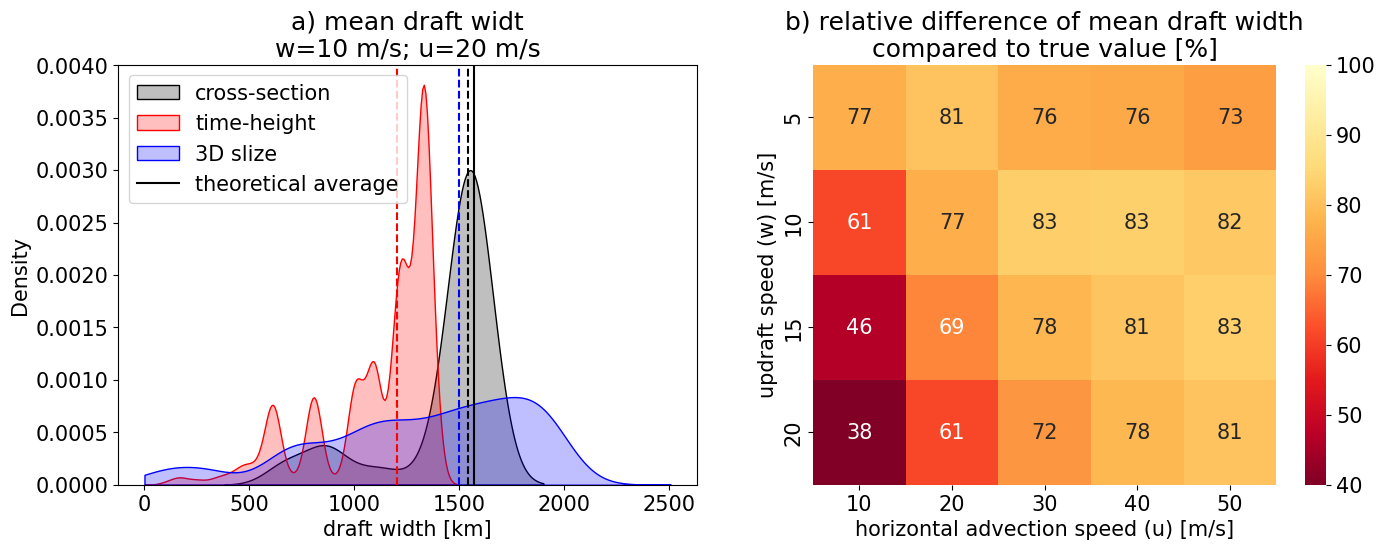

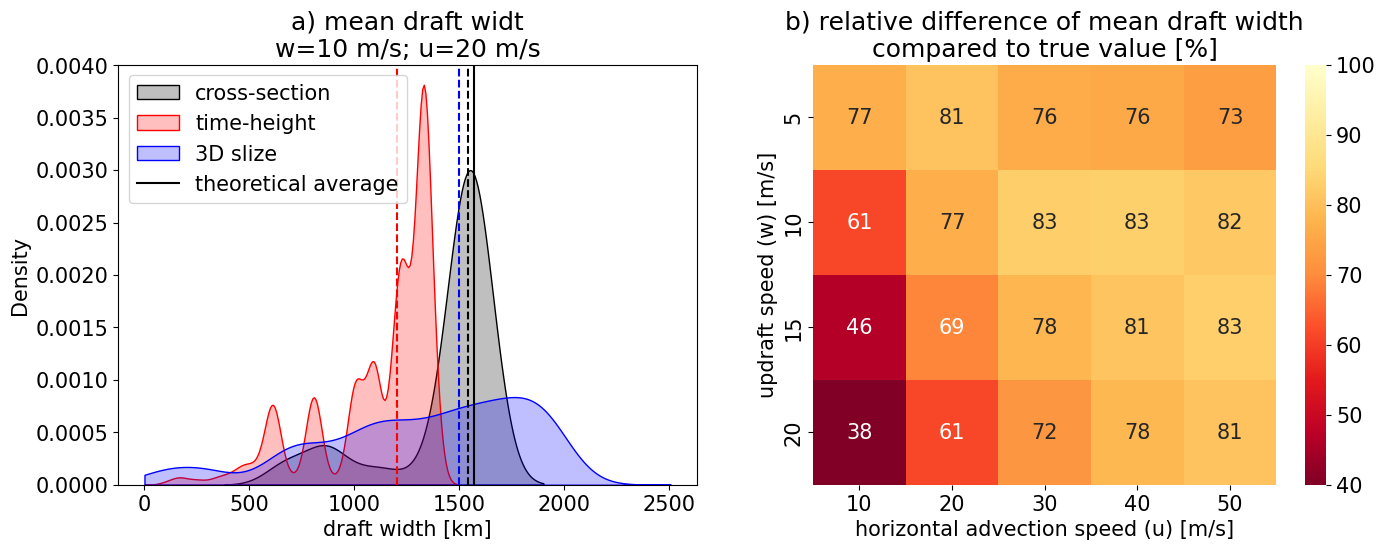

In [69]:
import seaborn as sns

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(14,5))
gs1 = gridspec.GridSpec(1,2) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.20, hspace=0.45)

# =============================================
### PLOT CORE MEAN WIDTH PDFS
ax = plt.subplot(gs1[0,0])

sns.kdeplot(mean_width_2d, shade=True, color="k", clip=[0, radius*3], label='cross-section')
plt.axvline(x=np.median(mean_width_2d), c='k', ls='--')
sns.kdeplot(mean_width_vp, shade=True, color="r", clip=[0, radius*3], label = 'time-height')
plt.axvline(x=np.median(mean_width_vp), c='r', ls='--')
sns.kdeplot(cores_3d['1'][stat].flatten(), shade=True, color="b", clip=[0, radius*3], label = '3D slize')
plt.axvline(x=np.median(cores_3d['1'][stat]), c='b', ls='--')

# fig = sns.kdeplot(mean_width_3d, shade=True, color="b", clip=[0, 100000])

plt.axvline(x=((np.pi*radius)/2), c='k', label='theoretical average')
ax.set_xlabel('draft width [km]')


draft_corespeed = 10
horizontal_advection = 20

plt.title('a) mean draft widt\nw='+str(draft_corespeed)+' m/s; u='+str(horizontal_advection)+' m/s')

plt.legend()


# =============================================
### PLOT HEATMAP OF MEAN WITH
ax = plt.subplot(gs1[0,1])

# core_stats_str = ['mean width', 'max width', 'mean depth', 'max depth']
df = pd.DataFrame((core_stats[0, core_stats_str.index('mean width'), :, :, 3]/((np.pi*radius)/2)) * 100., 
                  draft_corespeed_all, horizontal_advection_all)
p1 = sns.heatmap(df,
                 cmap = 'YlOrRd_r',
                 annot = True,
                 vmax = 100, vmin= 40)
ax.set_xlabel('horizontal advection speed (u) [m/s]')
ax.set_ylabel('updraft speed (w) [m/s]')
plt.title('b) relative difference of mean draft width\ncompared to true value [%]')

fig.savefig('Idealized_core_examples.pdf', bbox_inches='tight')
plt.show()